In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Preprocessed Data

In [2]:
data = pickle.load( open( "data.pkl", "rb" ) )
X_train, y_train, X_val, y_val, X_test, y_test = data

/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


### Define Model

In [3]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 256
        self.num_heads = 4
        self.num_jet_feats = 3
        self.num_trk_feats = 6
        
        self.jet_initializer = nn.Linear(self.num_jet_feats, self.embed_dim)
        self.jet_trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_trk_feats, self.embed_dim)
            
        self.multihead_attn_jet_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.jet_postprocess = nn.Linear(self.embed_dim*2, self.embed_dim)
       
        self.multihead_attn_trk = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.cross_post_layer_norm = nn.LayerNorm(self.embed_dim)
        self.cross_combined_layer_norm = nn.LayerNorm(self.embed_dim)
        self.cross_post_process = nn.Linear(self.embed_dim, self.embed_dim)

        self.multihead_attn_jet = nn.MultiheadAttention(self.embed_dim, self.num_heads,batch_first=True)        
        self.jet_post_layer_norm = nn.LayerNorm(self.embed_dim)
        self.jet_combined_layer_norm = nn.LayerNorm(self.embed_dim)
        self.jet_post_process = nn.Linear(self.embed_dim, self.embed_dim)

        self.post_process1 = nn.Linear(self.embed_dim, self.embed_dim*8)
        self.post_process2 = nn.Linear(self.embed_dim*8, self.embed_dim)
        self.regression = nn.Linear(self.embed_dim, 1)
        
    def forward(self, jets, jet_trks, trks):
        # Feature preprocessing layers
        jet_init = F.relu(self.jet_initializer(jets))
        jet_trk_init = F.relu(self.jet_trk_initializer(jet_trks))
        trk_init = F.relu(self.trk_initializer(trks))
        
        # Calculate aggregated tracks using attention
        query = jet_trk_init
        key = jet_trk_init
        value = jet_trk_init
        jet_trk_embedding, trk_weights = self.multihead_attn_jet_trk(query, key, value)
        
        # Generate meaningful jet_embedding using info from trk_aggregated  
        jet_trk_aggregated = jet_trk_embedding.sum(dim=1)
        jet_embedding = torch.cat((jet_init, jet_trk_aggregated),1)
        jet_embedding = F.relu(self.jet_postprocess(jet_embedding))

        # Cross Attention
        query = jet_embedding
        key = trk_init
        value = trk_init
        jet_attention, cross_weights = self.multihead_attn_trk(query, key, value)
        jet_attention = self.cross_post_layer_norm(jet_attention)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = self.cross_combined_layer_norm(jet_embedding)
        jet_embedding = F.relu(self.cross_post_process(jet_embedding))
        
        # Update embeddings of jets in the contex of entire event
        query = jet_embedding
        key = jet_embedding
        value = jet_embedding
        jet_attention, jet_weights = self.multihead_attn_jet(query, key, value)
        jet_attention = self.jet_post_layer_norm(jet_attention)
        jet_embedding = jet_embedding + jet_attention
        jet_embedding = self.jet_combined_layer_norm(jet_embedding)
        jet_embedding = F.relu(self.jet_post_process(jet_embedding))
        
        # Get output
        jet_embedding = F.relu(self.post_process1(jet_embedding))
        jet_embedding = F.relu(self.post_process2(jet_embedding))
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output, jet_weights, trk_weights, cross_weights

In [4]:
# Get Instance of the model
model = Model()
print(model)
print()

# Pass some data to the model and print outputs
Event_no = 0
Jets    = 0
Trk_Jet = 1
Trks     = 2
output, jet_weights, trk_weights, cross_weights = model(X_train[Event_no][Jets],X_train[Event_no][Trk_Jet],X_train[Event_no][Trks])
print(output.shape)
print(jet_weights.shape)
print(trk_weights.shape)
print(cross_weights.shape)

# Evaluate the loss
loss_fn = nn.MSELoss()
print(loss_fn(output,y_train[Event_no]))

Model(
  (jet_initializer): Linear(in_features=3, out_features=256, bias=True)
  (jet_trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (trk_initializer): Linear(in_features=6, out_features=256, bias=True)
  (multihead_attn_jet_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (jet_postprocess): Linear(in_features=512, out_features=256, bias=True)
  (multihead_attn_trk): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (cross_post_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (cross_combined_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (cross_post_process): Linear(in_features=256, out_features=256, bias=True)
  (multihead_attn_jet): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (jet_post_layer_norm): L

### Define Training Loop

In [5]:
def train(model, X_train, y_train, X_val, y_val, epochs=40):
    
    combined_history = []
    
    num_train = len(X_train)
    num_val = len(X_val)
    
    for e in range(epochs):
        model.train()
        cumulative_loss_train = 0

        for i in range(num_train):
            optimizer.zero_grad()
            
            output, jet_weights, trk_weights, cross_weights = model(X_train[i][0].to(device), X_train[i][1].to(device), X_train[i][2].to(device))
            
            loss=loss_fn(output, y_train[i].to(device))
            
            loss.backward()
            optimizer.step()
            
            cumulative_loss_train+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_train = cumulative_loss_train / num_train
        
        model.eval()
        cumulative_loss_val = 0
        for i in range(num_val):
            output, jet_weights, trk_weights, cross_weights = model(X_val[i][0].to(device), X_val[i][1].to(device), X_val[i][2].to(device))
            loss=loss_fn(output, y_val[i].to(device))
            
            cumulative_loss_val+=loss.detach().cpu().numpy().mean()
            
        cumulative_loss_val = cumulative_loss_val / num_val

        combined_history.append([cumulative_loss_train, cumulative_loss_val])

        if e%1==0:
            print('Epoch:',e,'\tTrain Loss:',round(cumulative_loss_train,6),'\tVal Loss:',round(cumulative_loss_val,6))

    return np.array(combined_history)

### Train Model

GPU Available:  True
cuda:0

Epoch: 0 	Train Loss: 0.157625 	Val Loss: 0.140562
Epoch: 1 	Train Loss: 0.133694 	Val Loss: 0.127023
Epoch: 2 	Train Loss: 0.116493 	Val Loss: 0.104446
Epoch: 3 	Train Loss: 0.092041 	Val Loss: 0.078898
Epoch: 4 	Train Loss: 0.071695 	Val Loss: 0.062755
Epoch: 5 	Train Loss: 0.060346 	Val Loss: 0.055153
Epoch: 6 	Train Loss: 0.054526 	Val Loss: 0.051197
Epoch: 7 	Train Loss: 0.05118 	Val Loss: 0.049145
Epoch: 8 	Train Loss: 0.049007 	Val Loss: 0.047349
Epoch: 9 	Train Loss: 0.047629 	Val Loss: 0.046391
Epoch: 10 	Train Loss: 0.04656 	Val Loss: 0.045762
Epoch: 11 	Train Loss: 0.045933 	Val Loss: 0.045075
Epoch: 12 	Train Loss: 0.04524 	Val Loss: 0.04438
Epoch: 13 	Train Loss: 0.044632 	Val Loss: 0.044465
Epoch: 14 	Train Loss: 0.044273 	Val Loss: 0.043517
Epoch: 15 	Train Loss: 0.043965 	Val Loss: 0.043552
Epoch: 16 	Train Loss: 0.043598 	Val Loss: 0.043076
Epoch: 17 	Train Loss: 0.04332 	Val Loss: 0.043047
Epoch: 18 	Train Loss: 0.043031 	Val Loss: 0.04294

Epoch: 157 	Train Loss: 0.024705 	Val Loss: 0.029263
Epoch: 158 	Train Loss: 0.024694 	Val Loss: 0.029686
Epoch: 159 	Train Loss: 0.02449 	Val Loss: 0.029305
Epoch: 160 	Train Loss: 0.024687 	Val Loss: 0.029303
Epoch: 161 	Train Loss: 0.024637 	Val Loss: 0.029947
Epoch: 162 	Train Loss: 0.024524 	Val Loss: 0.02945
Epoch: 163 	Train Loss: 0.024305 	Val Loss: 0.029468
Epoch: 164 	Train Loss: 0.024582 	Val Loss: 0.029173
Epoch: 165 	Train Loss: 0.024248 	Val Loss: 0.029454
Epoch: 166 	Train Loss: 0.024233 	Val Loss: 0.029757
Epoch: 167 	Train Loss: 0.024715 	Val Loss: 0.029193
Epoch: 168 	Train Loss: 0.024282 	Val Loss: 0.029564
Epoch: 169 	Train Loss: 0.024398 	Val Loss: 0.029651
Epoch: 170 	Train Loss: 0.02419 	Val Loss: 0.029503
Epoch: 171 	Train Loss: 0.023976 	Val Loss: 0.029407
Epoch: 172 	Train Loss: 0.023867 	Val Loss: 0.029427
Epoch: 173 	Train Loss: 0.023768 	Val Loss: 0.029633
Epoch: 174 	Train Loss: 0.023764 	Val Loss: 0.029414
Epoch: 175 	Train Loss: 0.023625 	Val Loss: 0.029

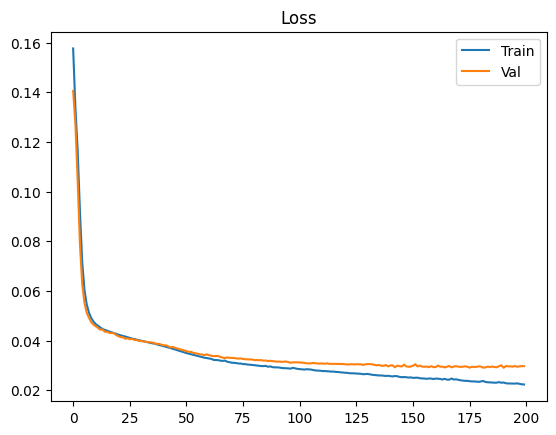

In [6]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print()

model = Model()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

loss_fn = nn.MSELoss()

combined_history = train(model, X_train, y_train, X_val, y_val,epochs=200)

plt.plot(combined_history[:,0], label="Train")
plt.plot(combined_history[:,1], label="Val")
plt.title('Loss')
plt.legend()
plt.show()

### Evaluate Model

Train Loss:	 0.02230540914510909
Val Loss:	 0.029679797207936644
Test Loss:	 0.03155769323464483

Test MAE:	 0.10240222024552469
Test RMSE:	 0.16683046684177813


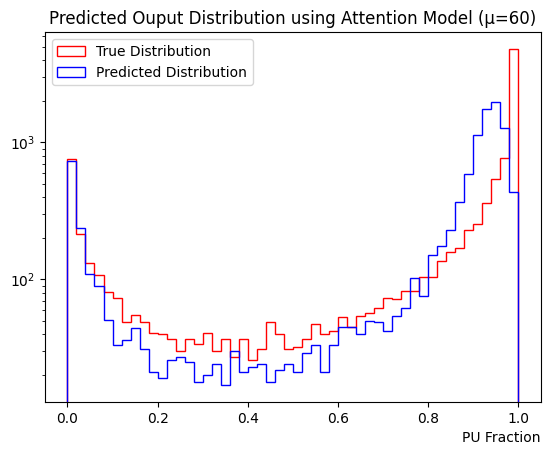

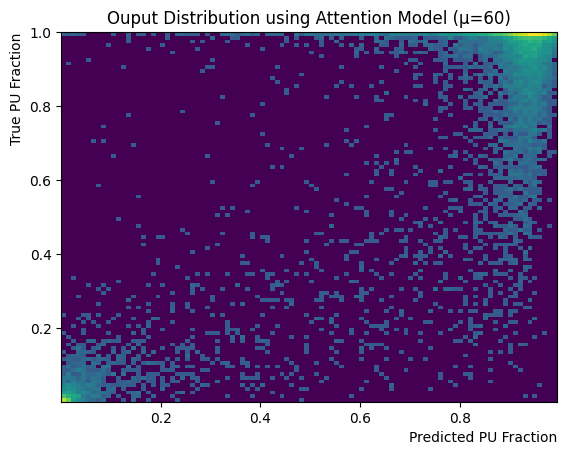

In [7]:
model.eval()
cumulative_loss_test = 0
cumulative_MSE_test = 0
cumulative_BCE_test = 0
predicted_labels = []
true_labels = []
binary_pred = []
binary_true = []

num_test = len(X_test)
for i in range(num_test):
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    loss=loss_fn(output, y_test[i].to(device))
    cumulative_loss_test+=loss.detach().cpu().numpy().mean()
        
    for j in range(output.shape[0]): 
        predicted_labels.append(float(output[j][0].detach().cpu().numpy()))
        true_labels.append(float(y_test[i][j][0].detach().numpy()))
    
cumulative_loss_test = cumulative_loss_test / num_test
    
print("Train Loss:\t", combined_history[-1][0])
print("Val Loss:\t", combined_history[-1][1])
print("Test Loss:\t", cumulative_loss_test)
print()
print("Test MAE:\t", mean_absolute_error(true_labels, predicted_labels))
print("Test RMSE:\t", root_mean_squared_error(true_labels, predicted_labels))

plt.hist(true_labels,histtype='step',color='r',label='True Distribution',bins=50,range=(0,1))
plt.hist(predicted_labels,histtype='step',color='b',label='Predicted Distribution',bins=50,range=(0,1))
plt.title("Predicted Ouput Distribution using Attention Model (\u03BC=60)")
plt.legend()
plt.yscale('log')
plt.xlabel('PU Fraction',loc='right')
plt.show()

plt.title("Ouput Distribution using Attention Model (\u03BC=60)")
plt.hist2d(predicted_labels,true_labels, bins=100,norm=mcolors.PowerNorm(0.2))
plt.xlabel('Predicted PU Fraction',loc='right')
plt.ylabel('True PU Fraction',loc='top')
plt.show()

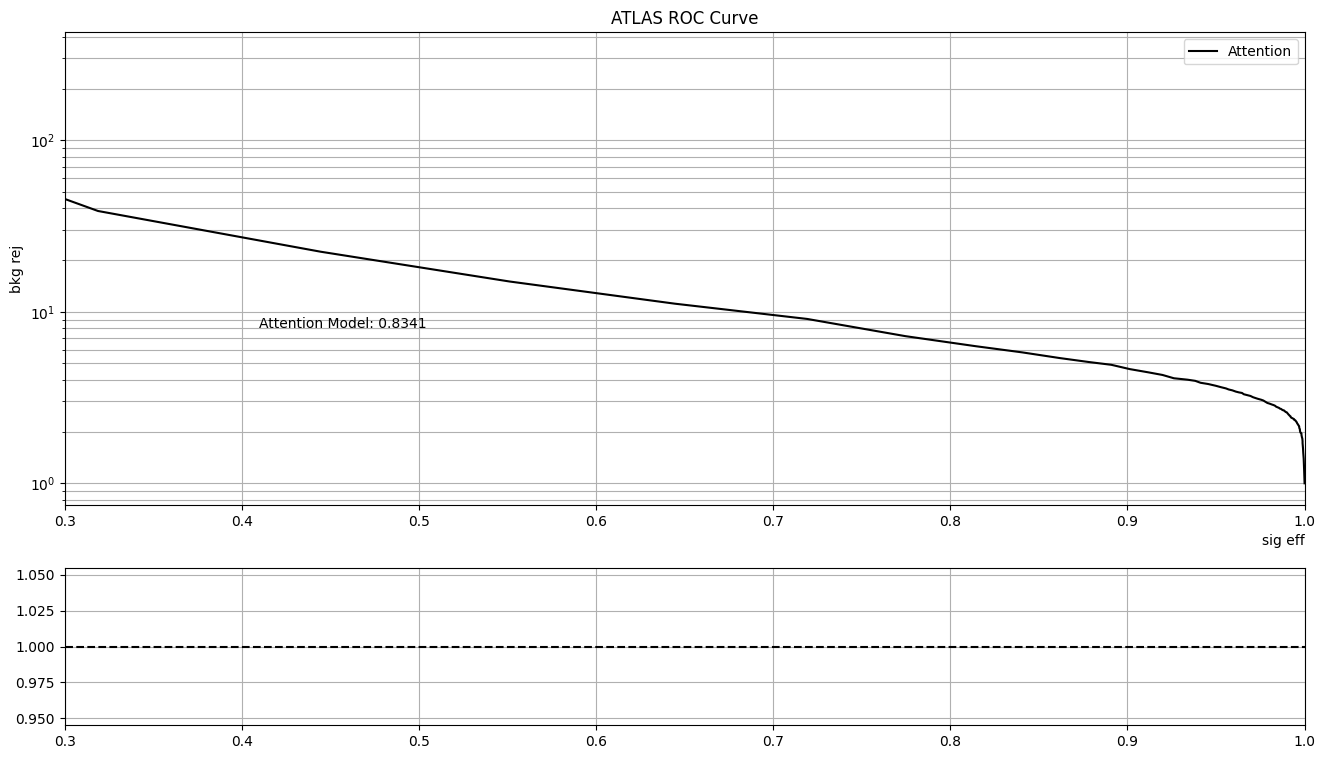

JVT	 Binary Accuracy:  0.9008280194156276 	F1 Score:  0.9363780681401881



In [10]:
def ATLAS_roc(y_true, y_pred):
    sig = (y_true==1)
    bkg = ~sig
    
    sig_eff = []
    bkg_eff = []
    
    thresholds = np.linspace(0,0.97,100)
    
    for threshold in thresholds:
        sig_eff.append(((y_pred[sig] > threshold).sum() / y_true[sig].shape[0]))
        bkg_eff.append(((y_pred[bkg] > threshold).sum()  / y_true[bkg].shape[0]))
        
    bkg_rej = [1/x for x in bkg_eff]
    return np.array(sig_eff), np.array(bkg_rej), thresholds

def get_metrics(y_true, y_pred, threshold):
    y_Pred = np.array(y_pred > threshold).astype(int)
    y_True = np.array(y_true > threshold).astype(int)
    x,y, thresholds = ATLAS_roc(y_True, y_pred)
    AUC = roc_auc_score(y_True, y_Pred)
    BA = accuracy_score(y_True, y_Pred)
    f1 = f1_score(y_True, y_Pred)
    return x,y,thresholds,AUC,BA,f1


fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,9), gridspec_kw={'height_ratios': [3, 1]})

x1,y1,th1,AUC1,BA1,f11 = get_metrics(np.array(true_labels), np.array(predicted_labels), 0.7)

ax1.set_title("ATLAS ROC Curve")
ax1.set_xlabel("sig eff",loc='right')
ax1.set_ylabel("bkg rej")

ax1.plot(x1,y1, label="Attention",color='k')
AUC1 = "Attention Model: " + str(round(AUC1,4))
ax1.text(0.41,8,AUC1)

x = 1-np.flip(th1)
ratio1 = np.interp(x,np.flip(x1),np.flip(y1))/np.interp(x,np.flip(x1),np.flip(y1))
ax2.plot(x,ratio1,linestyle='--',color='k')

# General Plot Settings
ax1.legend()
ax1.set_yscale('log')
ax1.grid(which='both')
ax2.grid(which='both')
ax1.set_xlim(0.3,1)
ax2.set_xlim(0.3,1)
plt.show()

print("JVT\t","Binary Accuracy: ", BA1, "\tF1 Score: ", f11)
print("")

### Visualize Attention Scores

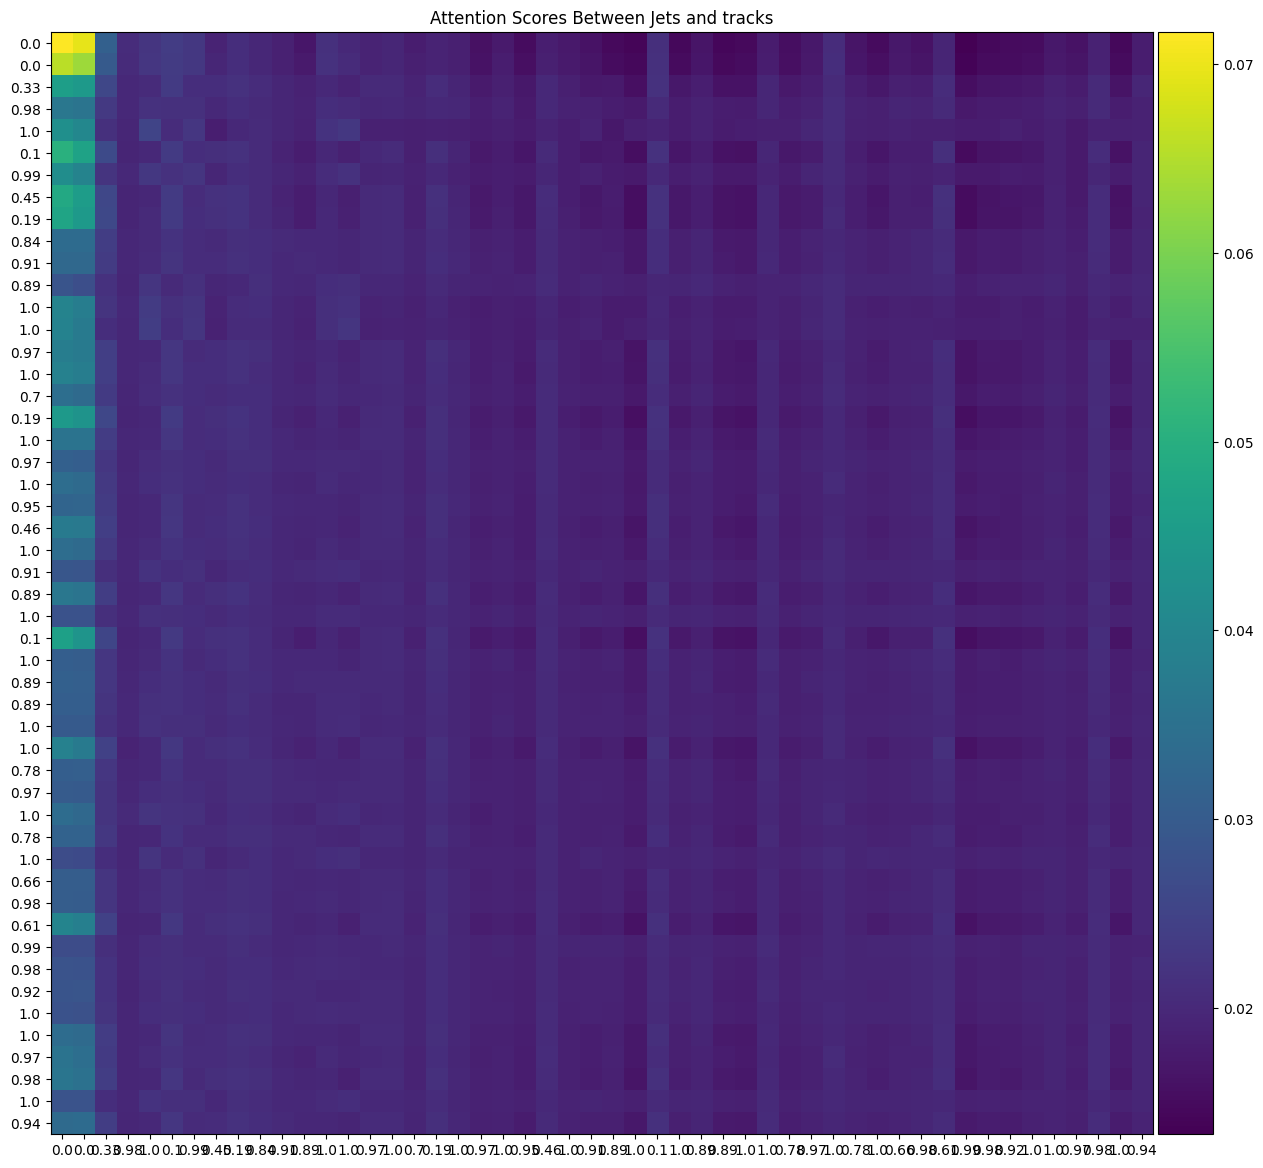

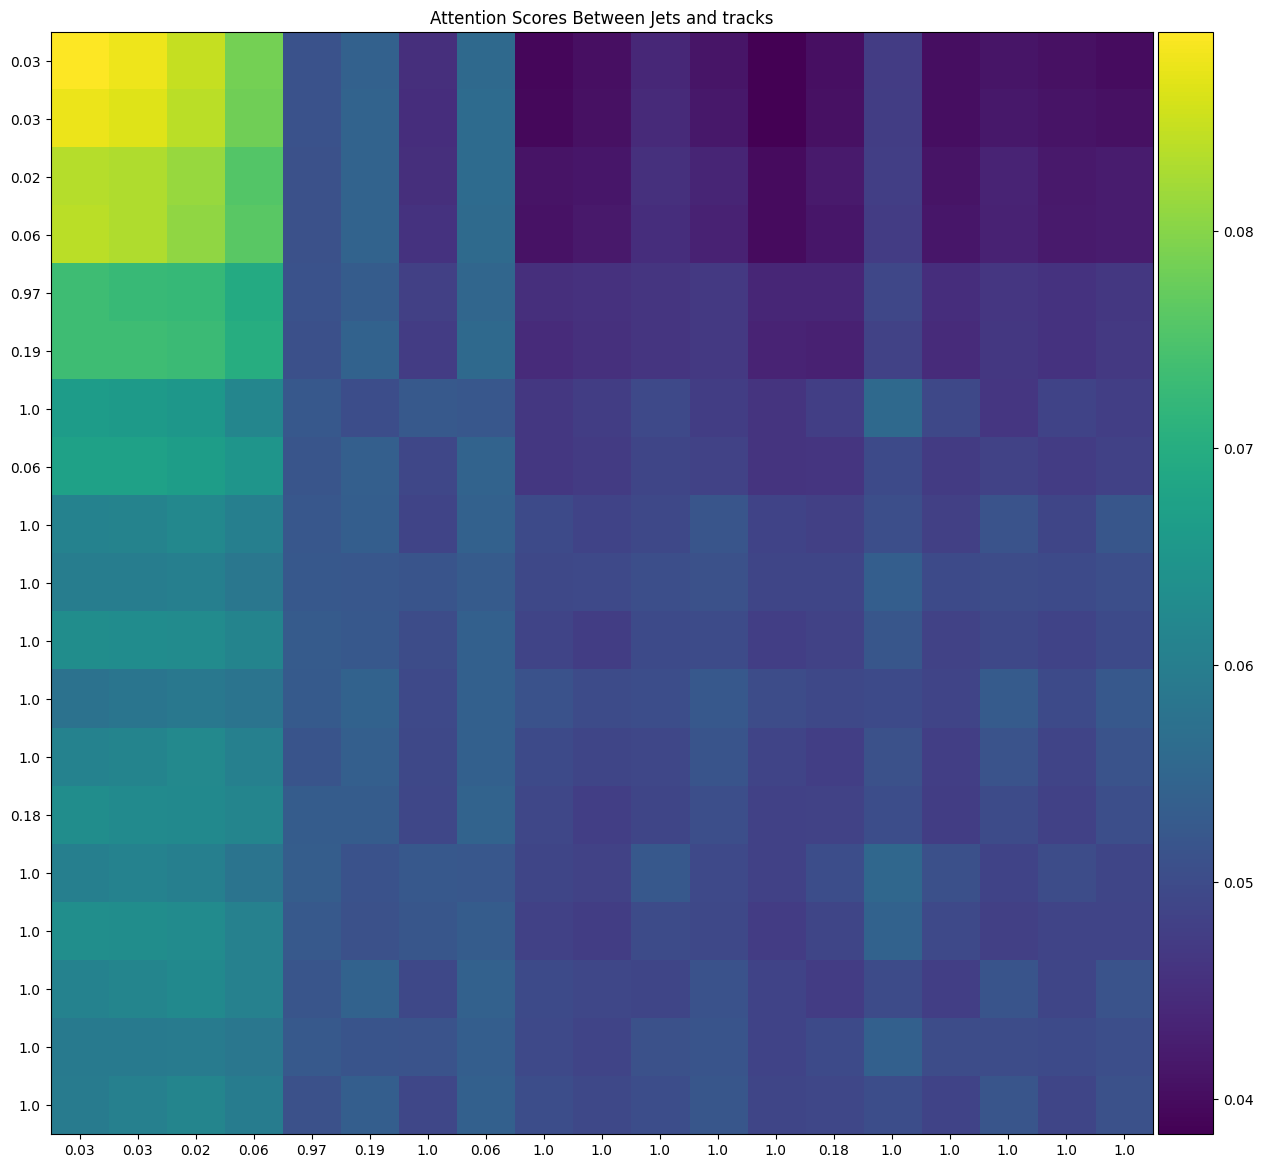

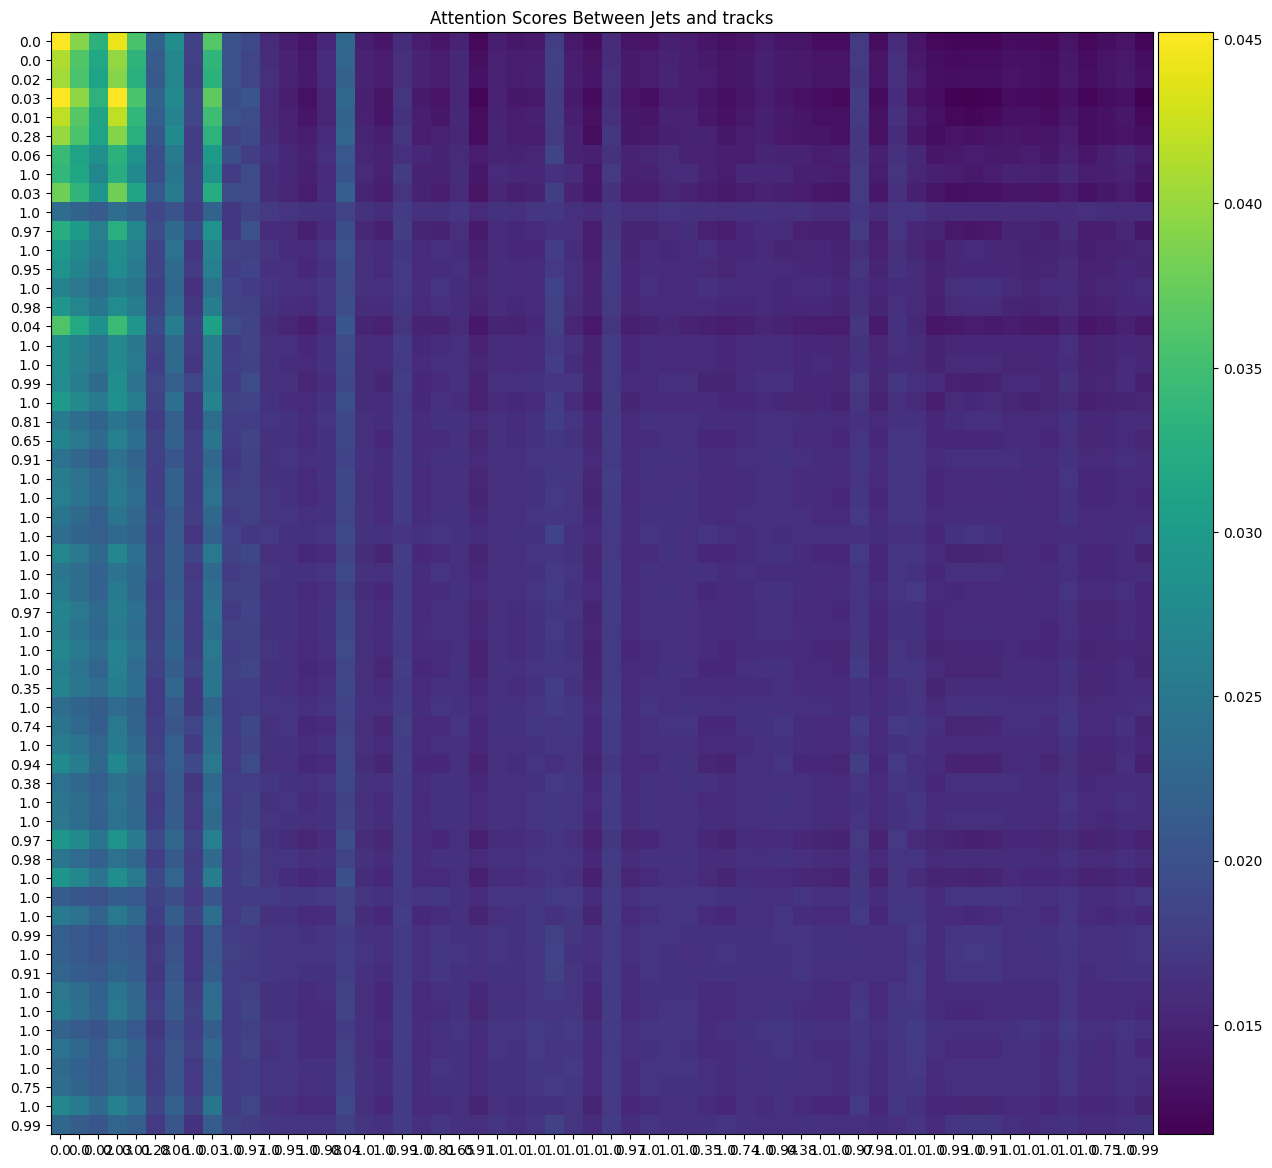

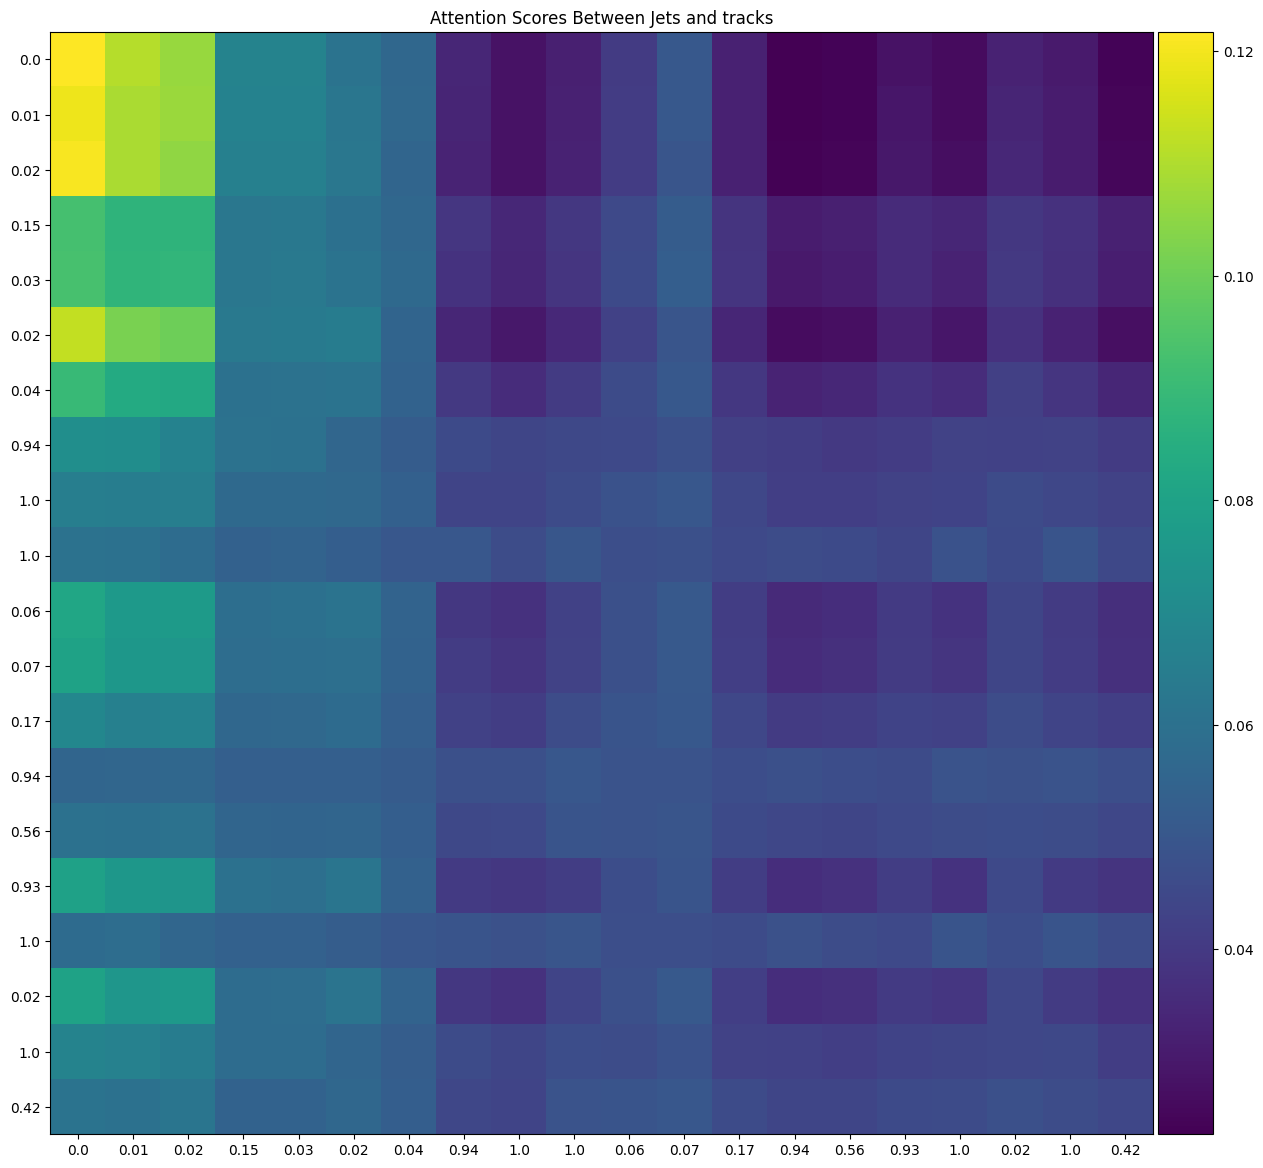

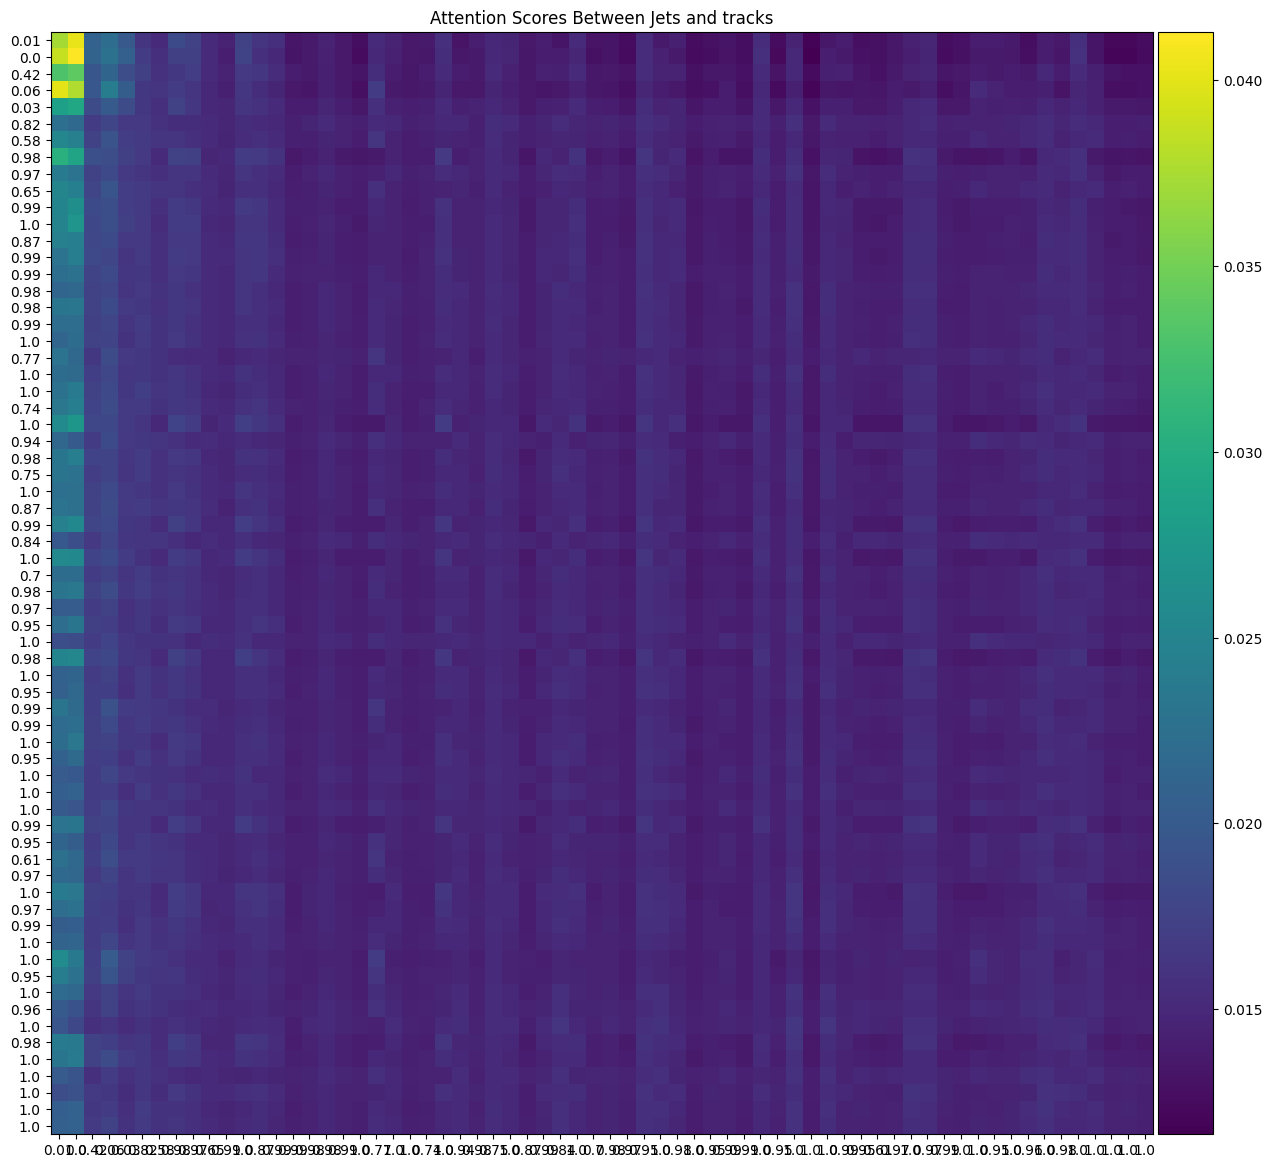

In [9]:
plot_events=5
for i in range(plot_events):
    # Get Model Predictions
    model.eval()
    output, jet_weights, trk_weights, cross_weights = model(X_test[i][0].to(device), X_test[i][1].to(device), X_test[i][2].to(device))
    
    num_jets = len(output)
    
    ticks = [x for x in range(num_jets)]
    jet_labels= [round(float(label.detach().cpu().numpy()[0]),2) for label in y_test[i]]   

    fig, (ax1) = plt.subplots(1, 1, figsize=(15,15))
    im0 = ax1.imshow(jet_weights.detach().cpu().numpy())
    ax1.set_xticks(ticks, jet_labels)
    ax1.set_yticks(ticks, jet_labels)
    ax1.set_title("Attention Scores Between Jets and tracks")
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im0, cax=cax, orientation='vertical')